In [1]:
%cd ..
%ls

/Users/matusbojko/Desktop/dp-project
LICENSE           main.ipynb        prepare.sh*       requirements.txt
README.md         notebooks/        project/          run/


/Users/matusbojko/Desktop/dp-project/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from project.datamodule import BaseDataSets, RandomGenerator,TwoStreamBatchSampler,patients_to_slices
from project.utils import worker_init_fn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import colors
from torchvision import transforms
import torch
import random
import numpy as np

In [3]:





def show_sample(image,label):

    # Convert PyTorch tensor (image) to NumPy array and squeeze the channel dimension if necessary
    if isinstance(image, np.ndarray):
        image_np = image  # Already a NumPy array
    else:
        image_np = image.numpy()  # Convert PyTorch tensor to NumPy array
    
    # Squeeze the singleton channel dimension (1, 254, 254) -> (254, 254)
    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)  # Remove the channel dimension

    # Define a color map for the labels: 0 (background), 1, 2, 3
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue'])  # Customize these colors as needed
    bounds = [0, 1, 2, 3, 4]  # Boundaries for the label values
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 5))

    # Plot the image (assuming it's grayscale)
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')  # Display image as grayscale
    plt.title('Image')

    # Plot the label with the custom color map
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap=cmap, norm=norm)  # Color the label based on defined cmap
    plt.colorbar(ticks=[0, 1, 2, 3])  # Show the color bar with label values
    plt.title('Colored Segmentation Mask')

    plt.show()

In [4]:
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.mps.manual_seed(1337)


db_train = BaseDataSets(base_dir="./project/ACDC", split="train", num=None, transform=transforms.Compose([
    RandomGenerator([256, 256])
]))

db_val = BaseDataSets(base_dir="./project/ACDC", split="val")

total_slices = len(db_train)
labeled_slice = patients_to_slices("ACDC", 7)
labeled_idxs = list(range(0, labeled_slice))
unlabeled_idxs = list(range(labeled_slice, total_slices))

batch_sampler = TwoStreamBatchSampler(labeled_idxs, unlabeled_idxs, 24, 24-12)

trainloader = DataLoader(db_train, batch_sampler=batch_sampler,num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valloader = DataLoader(db_val, batch_size=1, shuffle=False,num_workers=1)




total 1312 samples
total 20 samples


torch.Size([24, 1, 256, 256])
torch.Size([24, 256, 256])
0


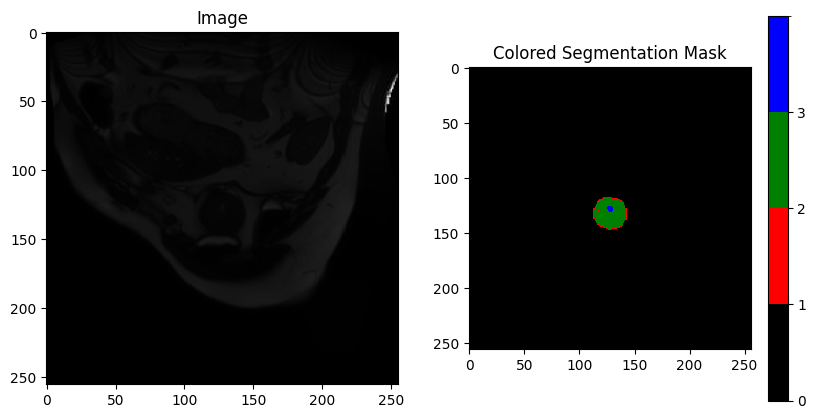

In [5]:
for i_batch, sampled_batch in enumerate(trainloader):
    volume_batch, label_batch = sampled_batch['image'], sampled_batch['label']
    print(volume_batch.shape)
    print(label_batch.shape)
    print(i_batch)
    show_sample(volume_batch[0],label_batch[0])
    if i_batch == 0:
        break

    